# Generative Adversarial Network
This is the 6th NNDL course HomeWork
By Ali Ranjbari

In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device is {device}')

device is cuda


## 1.Convolutional GANs

### I. Prepare the data

In [25]:
# !unzip -q Dataset.zip

In [26]:
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5)),
])

In [27]:
y_list = []
x_list = []
for class_num in range(1, 6):
  for img_name in os.listdir(f"./Dataset/Class {class_num}/"):
    if img_name.endswith(".png"):
      img = Image.open(f"./Dataset/Class {class_num}/{img_name}")
      x_list.append(transform(img).unsqueeze(0))
      y_list.append(class_num)

In [28]:
y = torch.tensor(y_list)
X = torch.concat(x_list)

In [29]:
class CustomDS(Dataset):
  def __init__(self, X):
    super().__init__()
    self.X = X
    self.y = y
  
  def __getitem__(self, idx):
     return self.X[idx]

  def __len__(self):
    return self.X.shape[0]


In [30]:
dataset = CustomDS(X)

### II. Model


In [31]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    # formular: (h-1) * stride  + (k-1) + 1

    self.fc = nn.Linear(100, 4*4*1024)  # 4 * 4
    self.bn = nn.BatchNorm2d(1024)
    self.conv_blocks = nn.Sequential(
      nn.ConvTranspose2d(1024, 512, 2, stride=2),   # 8 * 8
      nn.BatchNorm2d(512),
      nn.ReLU(),
      nn.ConvTranspose2d(512, 256, 2, stride=2),    # 16 * 16
      nn.BatchNorm2d(256),
      nn.ReLU(),
      nn.ConvTranspose2d(256, 128, 2, stride=2),    # 32 * 32
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.ConvTranspose2d(128, 1, 2, stride=2),      # 64 * 64
      nn.Tanh()
    )

  def forward(self, x):
    x = self.fc(x)
    x = x.view(-1, 1024, 4, 4)
    x = self.bn(x)
    x = self.conv_blocks(x)
    return x

In [32]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.conv_blocks = nn.Sequential(
      nn.Conv2d(1, 64, 4, stride=2, padding=1),
      nn.LeakyReLU(0.2),
      nn.Conv2d(64, 128, 4, stride=2, padding=1),
      nn.BatchNorm2d(128),
      nn.LeakyReLU(0.2),
      nn.Conv2d(128, 256, 4, stride=2, padding=1),
      nn.BatchNorm2d(256),
      nn.LeakyReLU(0.2),
      nn.Conv2d(256, 512, 4, stride=2, padding=1),
      nn.BatchNorm2d(512),
      nn.LeakyReLU(0.2),
    )
    self.fc = nn.Linear(4*4*512,1)

  def forward(self, x):
    x = self.conv_blocks(x)
    x = x.view(-1, 4*4*512)
    x = self.fc(x)
    return x


### III. Training loop

In [14]:
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [27]:
def weights_init(m):
		classname = m.__class__.__name__
		if classname.find('Conv') != -1:
			m.weight.data.normal_(0.0, 0.02)
		elif classname.find('BatchNorm') != -1:
			m.weight.data.normal_(1.0, 0.02)
			m.bias.data.fill_(0)

In [29]:
input_size = 100
generator = Generator().to(device)
discriminator = Discriminator().to(device)
generator.apply(weights_init)


lr = 0.0002
betas = (0.5, 0.9)
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=betas)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=betas)

criterion = nn.BCEWithLogitsLoss()
num_epochs = 100


d_losses = []
g_losses = []
accuracies = []

for epoch in range(num_epochs):
  for i, data in enumerate(dataloader):

    real_images = data.to(device)
    # Generate fake images
    noise = torch.randn(real_images.size(0), input_size).to(device)
    fake_images = generator(noise)

    # Train the discriminator
    optimizer_D.zero_grad()

    # Compute the loss for the real images
    real_output = discriminator(real_images)
    real_loss = criterion(real_output, torch.ones_like(real_output))

    accuracy = torch.sum(real_output >= 0).item() / real_output.shape[0]
    accuracies.append(accuracy)

    # Compute the loss for the fake images
    fake_output = discriminator(fake_images.detach())
    fake_loss = criterion(fake_output, torch.zeros_like(fake_output))

    d_loss = real_loss + fake_loss

    d_loss.backward()
    optimizer_D.step()

    # Train the generator
    optimizer_G.zero_grad()

    fake_output = discriminator(fake_images)
    g_loss = criterion(fake_output, torch.ones_like(fake_output))

    g_loss.backward()
    optimizer_G.step()

    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())

  if (epoch+1) % 5 == 0:
    print('Epoch [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, accuracy: {:.4f}'
      .format(epoch+1, num_epochs, d_loss.item(), g_loss.item(), accuracy))


Epoch [5/100], d_loss: 0.0103, g_loss: 13.4471, accuracy: 1.0000
Epoch [10/100], d_loss: 0.0940, g_loss: 4.2374, accuracy: 1.0000
Epoch [15/100], d_loss: 0.0606, g_loss: 5.0743, accuracy: 1.0000
Epoch [20/100], d_loss: 0.1864, g_loss: 3.8371, accuracy: 1.0000
Epoch [25/100], d_loss: 0.0761, g_loss: 4.9297, accuracy: 1.0000
Epoch [30/100], d_loss: 0.6375, g_loss: 3.8314, accuracy: 0.9633
Epoch [35/100], d_loss: 0.1392, g_loss: 3.8217, accuracy: 0.9817
Epoch [40/100], d_loss: 0.0779, g_loss: 4.5357, accuracy: 1.0000
Epoch [45/100], d_loss: 0.0672, g_loss: 5.0994, accuracy: 1.0000
Epoch [50/100], d_loss: 0.0258, g_loss: 6.2575, accuracy: 1.0000
Epoch [55/100], d_loss: 0.0259, g_loss: 5.5317, accuracy: 1.0000
Epoch [60/100], d_loss: 0.0472, g_loss: 6.4444, accuracy: 1.0000
Epoch [65/100], d_loss: 0.0215, g_loss: 6.0384, accuracy: 1.0000
Epoch [70/100], d_loss: 0.0277, g_loss: 5.7053, accuracy: 1.0000
Epoch [75/100], d_loss: 0.0219, g_loss: 6.0335, accuracy: 1.0000
Epoch [80/100], d_loss: 0

Now plot the two losses of generator and discriminator

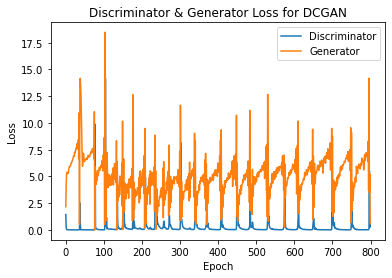

In [31]:
plt.plot(d_losses)
plt.plot(g_losses)
plt.title("Discriminator & Generator Loss for DCGAN")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(("Discriminator", "Generator"))
plt.show()

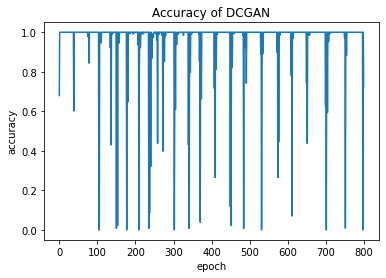

In [46]:
plt.plot(accuracies)
plt.title("Accuracy of DCGAN")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

### IV Generate Image  
generate 10 image

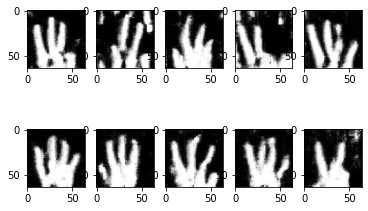

<Figure size 432x288 with 0 Axes>

In [66]:
with torch.no_grad():
  images = []
  for _ in range(10):
    noise = torch.randn(1, 100).to(device)
    generated_image = generator(noise)
    images.append(generated_image)

  f, axarr = plt.subplots(2,5)
  for i in range(2):
    for j in range(5):
      axarr[i][j].imshow(images[i*5+j][0][0].cpu(), 'gray')
  plt.figure()
  plt.show

### V. Train using One-Sided label Smoothing & Add Noise
We use One-sided label smoothing in line 35 that is we replace label 1 with 0.9   
And for Add Noise technique in line 33 & 42 we add noise to the fake and real image befor feeding them to discriminator


In [72]:
x = torch.zeros(5, 10, 20, dtype=torch.float64)
x = x + (0.1**0.5)*torch.randn(5, 10, 20)
x.shape

torch.Size([5, 10, 20])

In [73]:
input_size = 100
generator = Generator().to(device)
discriminator = Discriminator().to(device)
generator.apply(weights_init)


lr = 0.0002
betas = (0.5, 0.9)
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=betas)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=betas)

criterion = nn.BCEWithLogitsLoss()
num_epochs = 100


d_losses = []
g_losses = []
accuracies = []

for epoch in range(num_epochs):
  for i, data in enumerate(dataloader):

    real_images = data.to(device)
    # Generate fake images
    noise = torch.randn(real_images.size(0), input_size).to(device)
    fake_images = generator(noise)

    # Train the discriminator
    optimizer_D.zero_grad()

    # Compute the loss for the real images
    noise = torch.randn_like(real_images)       # random noise
    real_images_with_noise = real_images.add(noise)                               # Add Noise 
    real_output = discriminator(real_images_with_noise)
    real_loss = criterion(real_output, torch.ones_like(real_output) * 0.9)        # one-sided label smoothing replace 1 with 0.9

    accuracy = torch.sum(real_output >= 0).item() / real_output.shape[0]
    accuracies.append(accuracy)

    # Compute the loss for the fake images
    noise = torch.randn_like(fake_images.detach())  # random noise
    fake_images_with_noise = fake_images.add(noise)                               # Add Noise
    fake_output = discriminator(fake_images_with_noise.detach())
    fake_loss = criterion(fake_output, torch.zeros_like(fake_output))

    d_loss = real_loss + fake_loss

    d_loss.backward()
    optimizer_D.step()

    # Train the generator
    optimizer_G.zero_grad()

    fake_output = discriminator(fake_images)
    g_loss = criterion(fake_output, torch.ones_like(fake_output))

    g_loss.backward()
    optimizer_G.step()

    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())

  if (epoch+1) % 5 == 0:
    print('Epoch [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, accuracy: {:.4f}'
      .format(epoch+1, num_epochs, d_loss.item(), g_loss.item(), accuracy))


Epoch [5/100], d_loss: 0.4434, g_loss: 0.0213, accuracy: 1.0000
Epoch [10/100], d_loss: 0.3360, g_loss: 0.0082, accuracy: 1.0000
Epoch [15/100], d_loss: 0.3528, g_loss: 0.0148, accuracy: 1.0000
Epoch [20/100], d_loss: 0.3299, g_loss: 0.0083, accuracy: 1.0000
Epoch [25/100], d_loss: 0.3498, g_loss: 0.0056, accuracy: 1.0000
Epoch [30/100], d_loss: 0.3272, g_loss: 0.0092, accuracy: 1.0000
Epoch [35/100], d_loss: 0.6027, g_loss: 0.0758, accuracy: 0.6972
Epoch [40/100], d_loss: 0.3275, g_loss: 0.0103, accuracy: 1.0000
Epoch [45/100], d_loss: 0.3403, g_loss: 0.0113, accuracy: 1.0000
Epoch [50/100], d_loss: 0.3271, g_loss: 0.0071, accuracy: 1.0000
Epoch [55/100], d_loss: 0.3349, g_loss: 0.0126, accuracy: 1.0000
Epoch [60/100], d_loss: 0.3269, g_loss: 0.0076, accuracy: 1.0000
Epoch [65/100], d_loss: 0.3301, g_loss: 0.0071, accuracy: 1.0000
Epoch [70/100], d_loss: 0.3264, g_loss: 0.0065, accuracy: 1.0000
Epoch [75/100], d_loss: 0.3305, g_loss: 0.0109, accuracy: 1.0000
Epoch [80/100], d_loss: 0.

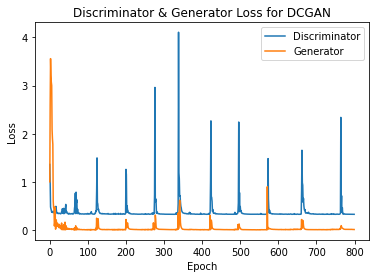

In [74]:
plt.plot(d_losses)
plt.plot(g_losses)
plt.title("Discriminator & Generator Loss for DCGAN")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(("Discriminator", "Generator"))
plt.show()

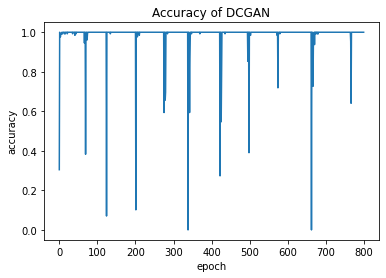

In [75]:
plt.plot(accuracies)
plt.title("Accuracy of DCGAN")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

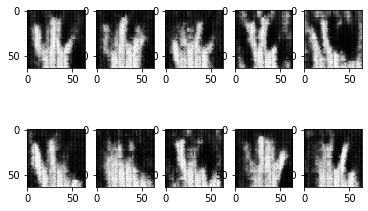

<Figure size 432x288 with 0 Axes>

In [76]:
with torch.no_grad():
  images = []
  for _ in range(10):
    noise = torch.randn(1, 100).to(device)
    generated_image = generator(noise)
    images.append(generated_image)

  f, axarr = plt.subplots(2,5)
  for i in range(2):
    for j in range(5):
      axarr[i][j].imshow(images[i*5+j][0][0].cpu(), 'gray')
  plt.figure()
  plt.show

## 2.1 AC-GAN

### I. Prepare the data

In [39]:
!unzip -q Dataset.zip

In [40]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [41]:
y_list = []
x_list = []
for class_num in range(1, 6):
  for img_name in os.listdir(f"./Dataset/Class {class_num}/"):
    if img_name.endswith(".png"):
      img = Image.open(f"./Dataset/Class {class_num}/{img_name}")
      x_list.append(transform(img).unsqueeze(0))
      y_list.append(class_num-1)

In [42]:
y = torch.tensor(y_list)
X = torch.concat(x_list)

In [43]:
class CustomDS(Dataset):
  def __init__(self, X, y):
    super().__init__()
    self.X = X
    self.y = y
  
  def __getitem__(self, idx):
     return self.X[idx], self.y[idx]


  def __len__(self):
    return self.X.shape[0]


In [44]:
dataset = CustomDS(X, y)

### II. Build the model


In [45]:
class Generator(nn.Module):
  def __init__ (self):
    super().__init__()
    # formular: (h-1) * stride  + (k-1) + 1

    self.fc = nn.Linear(110, 384)
    self.conv1 = nn.Sequential(     # 5 * 5
      nn.ConvTranspose2d(384, 192, 5, stride=2),
      nn.BatchNorm2d(192),
      nn.ReLU()
    )
    self.conv2 = nn.Sequential(     # 13 * 13
      nn.ConvTranspose2d(192, 96, 5, stride=2),
      nn.BatchNorm2d(96),
      nn.ReLU()
    )
    self.conv3 = nn.Sequential(     # 29 * 29
      nn.ConvTranspose2d(96, 3, 5, stride=2),
      nn.BatchNorm2d(3),
      nn.ReLU()
    )
    self.conv4 = nn.Sequential(     # 32 * 32
      nn.ConvTranspose2d(3, 1, 4, stride=1),
      nn.Tanh()
    )

  def forward(self, x):
    x = x.view(-1, 110)
    x = self.fc(x)
    x = x.view(-1, 384, 1, 1)
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    # print(x.shape)
    return x

In [46]:
class Discriminator(nn.Module):
  def __init__(self,classes=5):
    super(Discriminator,self).__init__()

    # formular (h + 2*pad - k) / stride  + 1
    self.conv1=nn.Sequential(     # 16 
      nn.Conv2d(1, 16, 3, stride=2, padding=1), 
      nn.LeakyReLU(0.2),
      nn.Dropout(0.5)
      )
    self.conv2=nn.Sequential(    # 16
      nn.Conv2d(16, 32, 3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.5)
      )
    self.conv3=nn.Sequential(   # 8
      nn.Conv2d(32, 64, 3, stride=2, padding=1),
      nn.BatchNorm2d(64),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.5)
      )
    self.conv4=nn.Sequential(   # 8
      nn.Conv2d(64, 128, 3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.5)
      )
    self.conv5=nn.Sequential(   # 4
      nn.Conv2d(128, 256, 3, stride=2, padding=1),
      nn.BatchNorm2d(256),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.5)
      )
    self.conv6=nn.Sequential(   # 4
      nn.Conv2d(256, 512, 3, stride=1, padding=1),
      nn.BatchNorm2d(512),
      nn.LeakyReLU(0.2),
      nn.Dropout(0.5)
      )
    self.fc_source = nn.Linear(4*4*512,1)
    self.fc_class = nn.Linear(4*4*512,classes)
    self.sig = nn.Sigmoid()
    self.soft = nn.Softmax(dim=1)

  def forward(self,x):

    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    x = self.conv6(x)
    x = x.view(-1,4*4*512)
    rf = self.sig(self.fc_source(x))
    c = self.soft(self.fc_class(x))
    
    return rf,c 


### III. Training Loop

First some utils function

In [47]:
def compute_acc(preds, labels):
	correct = 0
	preds_ = preds.data.max(1)[1]
	correct = preds_.eq(labels.data).cpu().sum()
	acc = float(correct) / float(len(labels.data)) * 100.0
	return acc

def weights_init(m):
		classname = m.__class__.__name__
		if classname.find('Conv') != -1:
			m.weight.data.normal_(0.0, 0.02)
		elif classname.find('BatchNorm') != -1:
			m.weight.data.normal_(1.0, 0.02)
			m.bias.data.fill_(0)

Now train

In [48]:
lr=0.0002
epochs=100
batch_size=100
real_label = torch.FloatTensor(batch_size).to(device)
real_label.fill_(1)

fake_label = torch.FloatTensor(batch_size).to(device)
fake_label.fill_(0)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
gen = Generator().to(device)
disc = Discriminator().to(device)

gen.apply(weights_init)

optimD = torch.optim.Adam(disc.parameters(),lr)
optimG = torch.optim.Adam(gen.parameters(),lr)

source_obj = nn.BCELoss()
class_obj = nn.NLLLoss()


g_losses = []
d_losses = []
accuracies = []
for epoch in range(epochs):
	for i,data in enumerate(dataloader,0):
		
		# Train Discriminator

		# real samples error
		optimD.zero_grad()

		image, label = data
		image, label = image.to(device), label.to(device)
		
		source_,class_= disc(image)
		source_error = source_obj(source_.squeeze(), real_label)
		class_error = class_obj(class_,label)
		error_real = source_error + class_error
		error_real.backward()
		optimD.step()


		accuracy = compute_acc(class_,label)
		accuracies.append(accuracy)
		
		
		# fake sample error
		noise_ = np.random.normal(0, 1, (batch_size, 110))
		
		label = np.random.randint(0,5,batch_size)
		
		noise = ((torch.from_numpy(noise_)).float())
		noise = noise.to(device)

		label = ((torch.from_numpy(label)).long())
		label = label.to(device)
		
		noise_image = gen(noise)

		source_,class_= disc(noise_image.detach())
		source_error = source_obj(source_.squeeze() ,fake_label)
		class_error = class_obj(class_, label)
		error_fake = source_error + class_error
		error_fake.backward()
		optimD.step()
		d_losses.append(error_fake.item())

		
		# Train Generator

		gen.zero_grad()
		source_,class_= disc(noise_image)
		source_error = source_obj(source_.squeeze(), real_label)
		class_error = class_obj(class_,label)
		error_gen = source_error+class_error
		error_gen.backward()
		optimG.step()
		g_losses.append(error_gen.item())

		# iteration_now = epoch * len(dataloader) + i


	if ((epoch+1) % 5 == 0):
		print("Epoch--[{} / {}], Loss_Discriminator--[{}], Loss_Generator--[{}], Accuracy--[{}]"
					.format(epoch+1, epochs, error_fake, error_gen, accuracy))

		

Epoch--[5 / 100], Loss_Discriminator--[-0.18220901489257812], Loss_Generator--[4.749013900756836], Accuracy--[84.0]
Epoch--[10 / 100], Loss_Discriminator--[-0.13631443679332733], Loss_Generator--[5.606662750244141], Accuracy--[96.0]
Epoch--[15 / 100], Loss_Discriminator--[0.0234280526638031], Loss_Generator--[6.590423107147217], Accuracy--[96.0]
Epoch--[20 / 100], Loss_Discriminator--[-0.08014917373657227], Loss_Generator--[4.048716068267822], Accuracy--[98.0]
Epoch--[25 / 100], Loss_Discriminator--[-0.17466624081134796], Loss_Generator--[6.803309917449951], Accuracy--[99.0]
Epoch--[30 / 100], Loss_Discriminator--[-0.17874868214130402], Loss_Generator--[6.6263227462768555], Accuracy--[95.0]
Epoch--[35 / 100], Loss_Discriminator--[-0.20542657375335693], Loss_Generator--[7.631516456604004], Accuracy--[97.0]
Epoch--[40 / 100], Loss_Discriminator--[-0.20329943299293518], Loss_Generator--[5.016239643096924], Accuracy--[98.0]
Epoch--[45 / 100], Loss_Discriminator--[-0.10779638588428497], Los

Plots

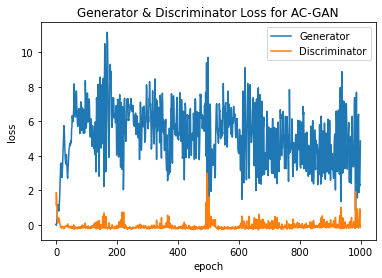

In [51]:
plt.plot(g_losses)
plt.plot(d_losses)
plt.title("Generator & Discriminator Loss for AC-GAN")
plt.legend(("Generator", "Discriminator"))
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

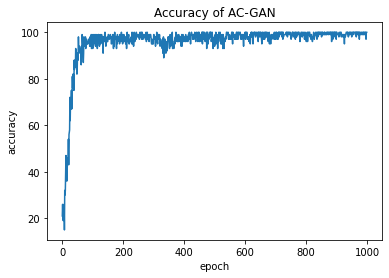

In [52]:
plt.plot(accuracies)
plt.title("Accuracy of AC-GAN")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

### IV. Generate image

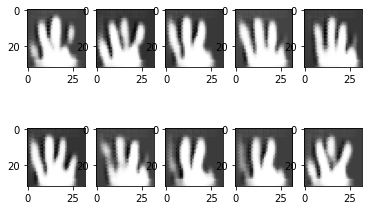

<Figure size 432x288 with 0 Axes>

In [55]:
with torch.no_grad():
  images = []
  for _ in range(10):
    noise = torch.randn(1, 110).to(device)
    generated_image = gen(noise)
    images.append(generated_image)

  f, axarr = plt.subplots(2,5)
  for i in range(2):
    for j in range(5):
      axarr[i][j].imshow(images[i*5+j][0][0].cpu(), 'gray')
  plt.figure()
  plt.show

## 2.2 WGAN

### I. Wasserstein Loss

In [14]:
class WassersteinLoss(nn.Module):
    def __init__(self):
        super(WassersteinLoss, self).__init__()

    def forward(self, real_output, fake_output):
        return -torch.mean(real_output - fake_output)

### II. Training

In [34]:
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [33]:
def weights_init(m):
		classname = m.__class__.__name__
		if classname.find('Conv') != -1:
			m.weight.data.normal_(0.0, 0.02)
		elif classname.find('BatchNorm') != -1:
			m.weight.data.normal_(1.0, 0.02)
			m.bias.data.fill_(0)

In [35]:
input_size = 100
generator = Generator().to(device)
discriminator = Discriminator().to(device)
generator.apply(weights_init)


lr = 0.0002
betas = (0.5, 0.9)
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=betas)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=betas)

# criterion = nn.BCEWithLogitsLoss()
criterion = WassersteinLoss()
num_epochs = 100


d_losses = []
g_losses = []
accuracies = []

for epoch in range(num_epochs):
  for i, data in enumerate(dataloader):

    real_images = data.to(device)
    # Generate fake images
    noise = torch.randn(real_images.size(0), input_size).to(device)
    fake_images = generator(noise)

    # Train the discriminator
    optimizer_D.zero_grad()

    # Compute the loss for the real images
    real_output = discriminator(real_images)
    # real_loss = criterion(real_output, torch.ones_like(real_output))

    accuracy = torch.sum(real_output >= 0).item() / real_output.shape[0]
    accuracies.append(accuracy)

    # Compute the loss for the fake images
    fake_output = discriminator(fake_images.detach())
    # fake_loss = criterion(fake_output, torch.zeros_like(fake_output))


    d_loss = criterion(real_output, fake_output)
    # d_loss = real_loss + fake_loss

    d_loss.backward()
    optimizer_D.step()

    # Train the generator
    optimizer_G.zero_grad()

    fake_output = discriminator(fake_images)
    g_loss = -torch.mean(fake_output)

    g_loss.backward()
    optimizer_G.step()

    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())

  if (epoch+1) % 5 == 0:
    print('Epoch [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, accuracy: {:.4f}'
      .format(epoch+1, num_epochs, d_loss.item(), g_loss.item(), accuracy))


Epoch [5/100], d_loss: -111.8001, g_loss: 54.1742, accuracy: 1.0000
Epoch [10/100], d_loss: -185.4712, g_loss: 91.8048, accuracy: 1.0000
Epoch [15/100], d_loss: -265.4796, g_loss: 132.6052, accuracy: 1.0000
Epoch [20/100], d_loss: -333.5026, g_loss: 167.5615, accuracy: 1.0000
Epoch [25/100], d_loss: -375.0219, g_loss: 214.2734, accuracy: 1.0000
Epoch [30/100], d_loss: -509.9335, g_loss: 255.0161, accuracy: 1.0000
Epoch [35/100], d_loss: -86.9095, g_loss: -175.3696, accuracy: 1.0000
Epoch [40/100], d_loss: -499.5272, g_loss: 292.5974, accuracy: 1.0000
Epoch [45/100], d_loss: -408.6720, g_loss: 72.7478, accuracy: 1.0000
Epoch [50/100], d_loss: -525.3870, g_loss: 30.8965, accuracy: 0.9908
Epoch [55/100], d_loss: -574.9540, g_loss: 330.0035, accuracy: 1.0000
Epoch [60/100], d_loss: -681.6783, g_loss: 237.6137, accuracy: 0.9633
Epoch [65/100], d_loss: -564.8624, g_loss: 36.2131, accuracy: 0.7339
Epoch [70/100], d_loss: -852.3943, g_loss: 462.0125, accuracy: 0.9908
Epoch [75/100], d_loss: -9

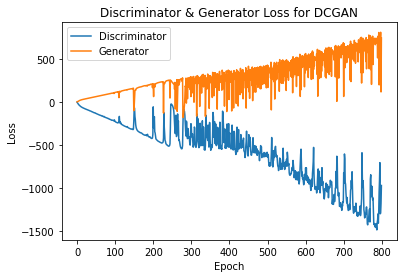

In [36]:
plt.plot(d_losses)
plt.plot(g_losses)
plt.title("Discriminator & Generator Loss for DCGAN")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(("Discriminator", "Generator"))
plt.show()

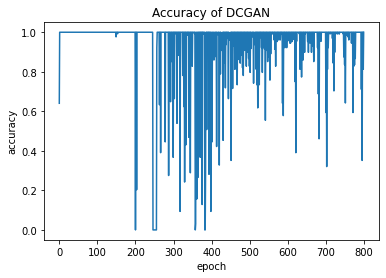

In [37]:
plt.plot(accuracies)
plt.title("Accuracy of DCGAN")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()

### III. Generate Image

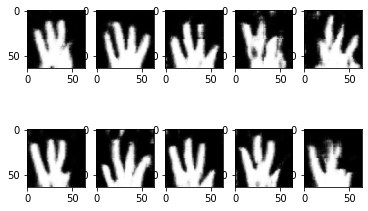

<Figure size 432x288 with 0 Axes>

In [38]:
with torch.no_grad():
  images = []
  for _ in range(10):
    noise = torch.randn(1, 100).to(device)
    generated_image = generator(noise)
    images.append(generated_image)

  f, axarr = plt.subplots(2,5)
  for i in range(2):
    for j in range(5):
      axarr[i][j].imshow(images[i*5+j][0][0].cpu(), 'gray')
  plt.figure()
  plt.show